In [22]:
%matplotlib inline
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import jieba as jb
import re
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import TaggedDocument
import multiprocessing


### EDA

In [3]:
df = pd.read_csv('./data/shopping.csv')
df=df[['cat','review']]
print("数据总量: %d ." % len(df))
df.sample(10)

数据总量: 62774 .


,cat,review
46230,衣服,放洗衣机里洗破了
18277,水果,这个苹果感觉是长熟的苹果，没有打蜡，不错，又甜又脆
34140,洗发水,左手边开封的是超市买的，右手边未开封的京东买的，居然没有QS标志，详细的大家可以对比看......
55755,酒店,酒店比较老，设施一般，但是服务相当好，价格也比较合理。值得推荐。
26964,洗发水,物流真给力，京东的物流一直都很棒，东西也很好，满意
9599,平板,连接无线平板会卡，质量太差
26055,水果,潘苹果也不甜，这次生鲜水果购货体验不好
17148,水果,新鲜水果，速度很快，已经来过很多次了，打折有优惠
22542,水果,个头不大，水分还可。就是苦的。不好
27544,洗发水,老公喜欢用清扬的，洗过头感觉很舒服，是正品哦，，包装也很好，京东值得你去信赖！


In [4]:
print("在 cat 列中总共有 %d 个空值." % df['cat'].isnull().sum())
print("在 review 列中总共有 %d 个空值." % df['review'].isnull().sum())
df[df.isnull().values==True]
df = df[pd.notnull(df['review'])]
df = df.reset_index(drop=True)

在 cat 列中总共有 0 个空值.
在 review 列中总共有 1 个空值.


   cat  count
0   衣服  10000
1   水果  10000
2  洗发水  10000
3   酒店  10000
4   平板  10000
5  计算机   3992
6   书籍   3851
7   手机   2323
8   蒙牛   2033
9  热水器    574


Text(0.5,0,'类目')

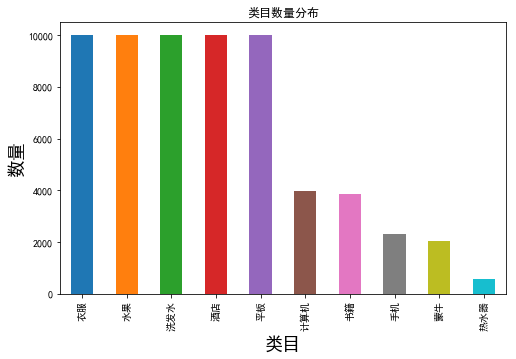

In [6]:
d = {'cat':df['cat'].value_counts().index, 'count': df['cat'].value_counts()}
df_cat = pd.DataFrame(data=d).reset_index(drop=True)
print(df_cat)

df_cat.plot(x='cat', y='count', kind='bar', legend=False,  figsize=(8, 5))
plt.title("类目数量分布")
plt.ylabel('数量', fontsize=18)
plt.xlabel('类目', fontsize=18)

### 数据清洗

In [11]:
#定义删除除字母,数字，汉字以外的所有符号的函数
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('',line)
    return line

#停用词列表
def stopwordslist(filepath):  
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]  
    return stopwords  

#加载停用词
stopwords = stopwordslist("./data/chineseStopWords.txt")

In [12]:
#删除除字母,数字，汉字以外的所有符号
df['clean_review'] = df['review'].apply(remove_punctuation)

#分词，并过滤停用词
# df['cut_review'] = df['clean_review'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
df['cut_review'] = df['clean_review'].apply(lambda x: [w for w in list(jb.cut(x)) if w not in stopwords])
df.head()


Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.898 seconds.
Prefix dict has been built succesfully.


,cat,review,clean_review,cut_review
0,书籍,﻿做父母一定要有刘墉这样的心态，不断地学习，不断地进步，不断地给自己补充新鲜血液，让自己保持...,做父母一定要有刘墉这样的心态不断地学习不断地进步不断地给自己补充新鲜血液让自己保持一颗年轻的...,"[做, 父母, 一定, 刘墉, 心态, 不断, 学习, 不断, 进步, 不断, 补充, 新鲜..."
1,书籍,作者真有英国人严谨的风格，提出观点、进行论述论证，尽管本人对物理学了解不深，但是仍然能感受到...,作者真有英国人严谨的风格提出观点进行论述论证尽管本人对物理学了解不深但是仍然能感受到真理的火...,"[作者, 真有, 英国人, 严谨, 风格, 提出, 观点, 进行, 论述, 论证, 物理学,..."
2,书籍,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点。为什么荷兰曾经县有欧洲最高的生产...,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点为什么荷兰曾经县有欧洲最高的生产率...,"[作者, 长篇大论, 借用, 详细, 报告, 数据处理, 工作, 计算结果, 支持, 其新,..."
3,书籍,作者在战几时之前用了＂拥抱＂令人叫绝．日本如果没有战败，就有会有美军的占领，没胡官僚主义的延...,作者在战几时之前用了拥抱令人叫绝日本如果没有战败就有会有美军的占领没胡官僚主义的延续没有战后...,"[作者, 战, 之前, 拥抱, 令人, 叫绝, 日本, 没有, 战败, 会, 美军, 占领,..."
4,书籍,作者在少年时即喜阅读，能看出他精读了无数经典，因而他有一个庞大的内心世界。他的作品最难能可贵...,作者在少年时即喜阅读能看出他精读了无数经典因而他有一个庞大的内心世界他的作品最难能可贵的有两...,"[作者, 少年, 时即, 喜, 阅读, 看出, 精读, 无数, 经典, 一个, 庞大, 内心..."


In [16]:
def print_cut_review(index):
    example = df[df.index == index][['cut_review', 'cat']].values[0]
    if len(example) > 0:
        print(example[0])
        print('cat:', example[1])
        
print_cut_review(10)
print_cut_review(500)

['作者', '力', '马克思', '注意', '经济学', '角度', '剖析', '当代', '中国', '经济', '细心', '人会', '发现', '中国', '近', '20', '年', '政策措施', '何新', '先生', '文章', '里', '找到', '蛛丝马迹', '作者', '早', '2001', '年', '预言', '十年', '世界', '会', '爆发', '大规模', '金融危机', '非常', '难得', '原因', '作者', '数据', '统计', '严密', '逻辑推理', '国家', '发展', '大计', '重任', '知识分子', '现在', '不多见', '看看', '上市公司', '独立', '懂事', '知道', '认为', '何先生', '了不起', '知识分子']
cat: 书籍
['喜欢', '张爱玲', '拥有', '两套', '张爱玲', '全集', '新出', '书', '买', '当当', '实惠', '爱到', '好像', '本书', '当做', '广告', '熟悉', '张爱玲', '喜欢', '文字', '劝', '不要', '买', '本书', '沿袭', '张', '风范', '有点', '晦涩', '难懂', '需要', '用心', '仔细阅读', '喜欢', '张', '一定', '读', '下去', '值得', '表扬', '出版商', '封面设计', '真不错', '个人', '非常', '喜欢', '装帧', '考究', '觉得', '超值']
cat: 书籍


### 创建训练集和测试集

In [21]:
#创建训练集和测试集
train, test = train_test_split(df, test_size=0.3, random_state=42,stratify = df.cat.values)

#创建标签化文档
train_tagged = train.apply(
    lambda r: TaggedDocument(words=r['cut_review'], tags=[r['cat']]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=r['cut_review'], tags=[r['cat']]), axis=1)

train_tagged.values[30]

TaggedDocument(words=['平心而论', '价位', '房间', '应该', '算', '不错', '没有', '碰到', '下面', '几件', '事情', '拿到', '房卡', '房间', '居然', '没有', '打扫', '房门', '锁', '发生', '两次', '故障', '锁', '外面', '不用', '钥匙', '打开', '服务员', '很快', '修好', '总是', '怕怕', '宾馆', '主楼', '一道', '边门', '直接', '通往', '公园', '通道', '居然', '门大开', '没有', '门卫', '安保', '措施', '这道', '门', '直接', '二楼', '客房', '走廊', '走廊', '探头', '安全措施', '总让', '放心', '个人感觉', '餐厅', '菜', '太贵', '一盘', '糖醋排骨', '68', '元', '没敢', '点', '要求', '不高', '早上', '自助餐'], tags=['酒店'])

In [24]:
#CPU内核数
cores = multiprocessing.cpu_count()

### 训练DBOW模型

In [41]:
from gensim.models import Doc2Vec
from tqdm import tqdm

model_dbow = Doc2Vec(dm=0,  negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 43941/43941 [00:00<00:00, 2494442.88it/s]


In [42]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 43941/43941 [00:00<00:00, 3045456.85it/s]


CPU times: user 1min 21s, sys: 20.4 s, total: 1min 41s
Wall time: 1min 15s


### 生成文档特征向量

In [43]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

#生成特征向量
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

### 预测和评估

In [44]:
#使用逻辑回归来预测
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [45]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.7770284621920136
Testing F1 score: 0.7772072575572019


### DM模型创建和训练

In [47]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 43941/43941 [00:00<00:00, 2471263.81it/s]


In [48]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 43941/43941 [00:00<00:00, 3057227.66it/s]


CPU times: user 2min 36s, sys: 1min 58s, total: 4min 34s
Wall time: 3min 9s


In [50]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.33804163126593034
Testing F1 score: 0.3107571794952185


### 合成新模型

In [51]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [52]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [53]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.7891886151231946
Testing F1 score: 0.7899100861776134
